In [2]:
import pandas as pd

# Load CSV file
df = pd.read_csv("/kaggle/input/country-flag/countries_flags.csv")

# Assuming the column containing the paths is named 'path'
df['flag_path'] = df['flag_path'].str.replace(r'flag_images/', '/kaggle/input/flags-codes/', regex=True)

# Save the modified CSV
df.to_csv("updated_countries_flags.csv", index=False)

# Display a preview
df.head()


,country_code,country_name,flag_path
0,ad,Andorra,/kaggle/input/flags-codes/ad.jpg
1,ae,United Arab Emirates,/kaggle/input/flags-codes/ae.jpg
2,af,Afghanistan,/kaggle/input/flags-codes/af.jpg
3,ag,Antigua and Barbuda,/kaggle/input/flags-codes/ag.jpg
4,ai,Anguilla,/kaggle/input/flags-codes/ai.jpg


<ipython-input-3-134a300c6b0b>:17: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(image)
<ipython-input-3-134a300c6b0b>:17: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(image)
<ipython-input-3-134a300c6b0b>:17: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(image)
<ipython-input-3-134a300c6b0b>:17: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(image)


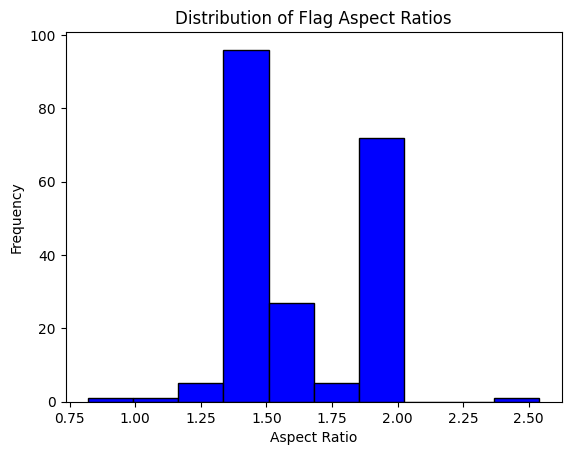

In [3]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load CSV file
df = pd.read_csv("/kaggle/working/updated_countries_flags.csv")

# Function to extract dominant colors
def get_dominant_colors(image_path, k=3):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((-1, 3))
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(image)
    
    return kmeans.cluster_centers_

# Extract dominant colors and aspect ratio
dominant_colors = []
aspect_ratios = []

for path in df["flag_path"]:
    try:
        # Read image
        img = cv2.imread(path)
        h, w, _ = img.shape
        aspect_ratios.append(w / h)
        
        # Get dominant colors
        colors = get_dominant_colors(path)
        dominant_colors.append(colors)
    except:
        aspect_ratios.append(None)
        dominant_colors.append(None)

df["aspect_ratio"] = aspect_ratios
df["dominant_colors"] = dominant_colors

# Save the enhanced dataset
df.to_csv("flag_analysis.csv", index=False)

# Plot aspect ratio distribution
plt.hist(df["aspect_ratio"].dropna(), bins=10, color="blue", edgecolor="black")
plt.xlabel("Aspect Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Flag Aspect Ratios")
plt.show()


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from glob import glob
from skimage.feature import canny
from skimage.color import rgb2gray

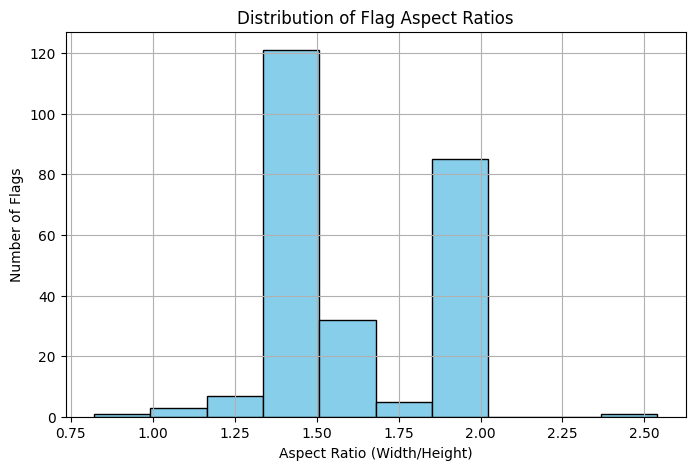

In [10]:
# Path to flag images dataset
flag_images_path = "/kaggle/input/flags-codes/"

# Load flag image file paths
flag_files = glob(os.path.join(flag_images_path, "*.jpg"))

# Initialize lists to store data
flag_data = []

def get_dominant_colors(image, n_clusters=5):
    pixels = np.array(image).reshape(-1, 3)  # Flatten image to (num_pixels, 3)
    unique_colors = np.unique(pixels, axis=0)
    
    # If unique colors are fewer than clusters, reduce clusters
    n_clusters = min(len(unique_colors), n_clusters)
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_  # Dominant colors


for flag_path in flag_files:
    # Read image
    image = cv2.imread(flag_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get image shape (height, width, channels)
    height, width, _ = image.shape
    aspect_ratio = width / height
    
    # Extract dominant colors
    dominant_colors = get_dominant_colors(image)
    
    # Convert to grayscale and detect edges
    gray_image = rgb2gray(image)
    edges = canny(gray_image).sum()
    
    # Store data
    flag_data.append({
        "country": os.path.basename(flag_path).split(".")[0],
        "path": flag_path,
        "height": height,
        "width": width,
        "aspect_ratio": aspect_ratio,
        "edge_count": edges,  # Edge count as a rough estimate of patterns
        "dominant_colors": dominant_colors.tolist()
    })

# Convert to DataFrame
df_flags = pd.DataFrame(flag_data)

# 1. Plot distribution of aspect ratios
plt.figure(figsize=(8, 5))
plt.hist(df_flags["aspect_ratio"], bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Number of Flags")
plt.title("Distribution of Flag Aspect Ratios")
plt.grid(True)
plt.show()



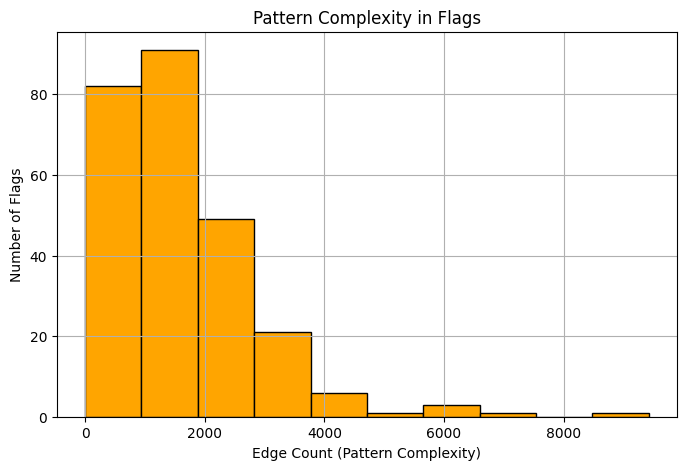

In [7]:
# 2. Plot edge detection results
plt.figure(figsize=(8, 5))
plt.hist(df_flags["edge_count"], bins=10, color='orange', edgecolor='black')
plt.xlabel("Edge Count (Pattern Complexity)")
plt.ylabel("Number of Flags")
plt.title("Pattern Complexity in Flags")
plt.grid(True)
plt.show()

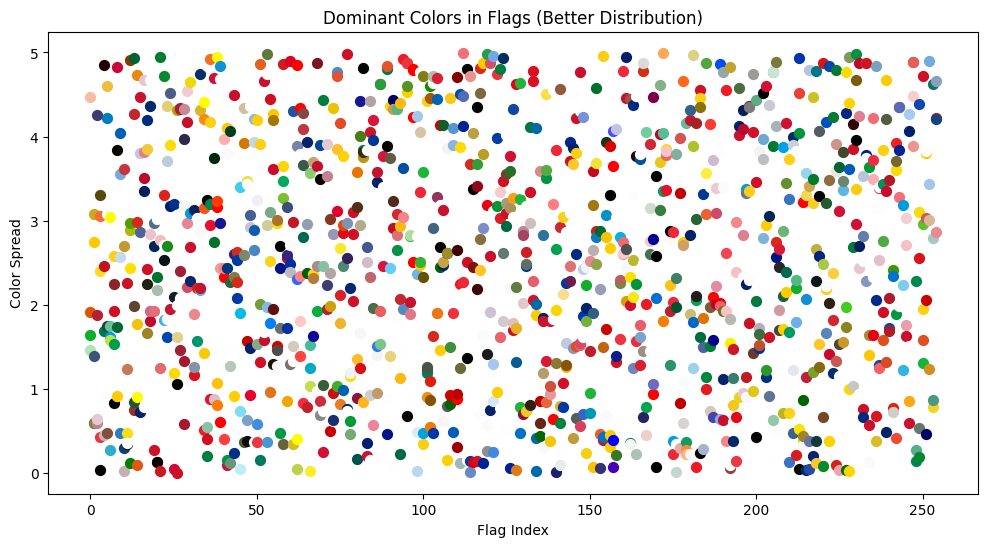

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for idx, row in df_flags.iterrows():
    num_colors = len(row["dominant_colors"])
    for i, color in enumerate(row["dominant_colors"]):
        color_array = np.array(color)
        if color_array.max() <= 1:  # Scale colors if needed
            color_array *= 255
        plt.scatter(idx, np.random.uniform(0, 5),  # Randomize y-axis for better separation
                    color=color_array.astype(int) / 255, s=50)

plt.xlabel("Flag Index")
plt.ylabel("Color Spread")
plt.title("Dominant Colors in Flags (Better Distribution)")
plt.show()


In [15]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from PIL import Image

# List of country flag image files (assuming all images are in a folder named 'flags/')
flags_folder = "/kaggle/input/flags-codes"
flag_files = [f for f in os.listdir(flags_folder) if f.endswith(".png") or f.endswith(".jpg")]

data = []

def get_dominant_color(image_path, n_clusters=3):
    """Extracts dominant colors from an image using KMeans clustering."""
    image = Image.open(image_path).convert("RGB")  # Convert to RGB to ensure 3 channels
    pixels = np.array(image)

    if len(pixels.shape) == 2:  # Check if the image is grayscale
        print(f"Skipping grayscale image: {image_path}")
        return [(0, 0, 0)]  # Default black if grayscale (or handle differently)

    pixels = pixels.reshape(-1, 3)  # Ensure proper shape (num_pixels, 3)
    
    unique_colors = np.unique(pixels, axis=0)
    n_clusters = min(len(unique_colors), n_clusters)  # Ensure valid cluster count
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_  # Returns dominant colors

# Loop through each flag image
for file in flag_files:
    country_name = os.path.splitext(file)[0]  # Extract country name from filename
    image_path = os.path.join(flags_folder, file)
    
    dominant_colors = get_dominant_color(image_path, n_clusters=1)  # Get the top color
    main_color = tuple(map(int, dominant_colors[0]))  # Convert to integer (RGB)
    
    data.append([country_name, main_color])

# Create DataFrame and save to CSV
df = pd.DataFrame(data, columns=["Country", "Dominant Color (RGB)"])
df.to_csv("flag_colors.csv", index=False)

print("CSV file 'flag_colors.csv' created successfully!")


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


CSV file 'flag_colors.csv' created successfully!


In [16]:
df.head()

,Country,Dominant Color (RGB)
0,ne,"(162, 161, 87)"
1,eu,"(7, 55, 148)"
2,us,"(186, 126, 143)"
3,be,"(164, 89, 33)"
4,eh,"(93, 97, 81)"


In [18]:
dominant_colors_list = []  # Store dominant colors
country_list = []  # Store country names

for file in os.listdir(flags_folder):
    if file.endswith(".png") or file.endswith(".jpg"):
        image_path = os.path.join(flags_folder, file)
        country_name = os.path.splitext(file)[0]  # Extract country name from filename
        
        # Extract the dominant color
        dominant_colors = get_dominant_color(image_path, n_clusters=1)  # Use 1 cluster for the main color
        main_color = tuple(map(int, dominant_colors[0]))  # Convert to integer (RGB)
        
        dominant_colors_list.append(main_color)
        country_list.append(country_name)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
